In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import pickle as plk
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def create_our_columns(dataframe):
    grouped = dataframe.groupby('ident')
    masa_total = grouped.sum()['emepla(i)/emet']
    eficiencia = masa_total/(grouped['emed'].first())
    n_planetas = grouped.size()
    
    n_planetas.name = 'nplanets'
    masa_total.name = 'tmass'
    eficiencia.name = 'eff'
    
    new = dataframe.join(n_planetas, on='ident')
    new = new.join(masa_total, on='ident')
    new = new.join(eficiencia, on='ident')
    
    return new

def scalate(splitted_data):
    X_train, X_test, Y_train, Y_test = splitted_data
    if len(Y_train.shape) == 1:
        Y_train = Y_train.values.reshape((-1, 1))
        Y_test = Y_test.values.reshape((-1, 1))
        
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_ = scaler.transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    scaler = preprocessing.StandardScaler().fit(Y_train)
    Y_train_ = scaler.transform(Y_train)
    Y_test_ = scaler.transform(Y_test)
    
    return X_train_, X_test_, Y_train_, Y_test_

In [3]:
def lasso_test(data, n_keys, lambdas):
    N = len(lambdas)
    
    X_train, X_test, Y_train, Y_test = data
    
    coefs_norm = np.zeros((N, n_keys + 1))
    scores_norm = np.zeros(N)

    for i in range(N):
        clf = Lasso(alpha = lambdas[i])
        clf.fit(X_train, Y_train)
        coefs_norm[i, 0] = clf.intercept_
        coefs_norm[i, 1:] = clf.coef_
        scores_norm[i] = clf.score(X_test, Y_test)
        
    return coefs_norm, scores_norm
    
def multiple_lasso_testing(dataframe, wanted_index = 0, number_of_test = 1):
    grouped = dataframe.groupby('ident')
    data = grouped.mean()
    keys = list(data.keys())
    wanted = ['nplanets', 'tmass', 'eff']
    to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

    for key in to_remove:
        keys.remove(key)
        
    X_data = data[keys]
    Y_data = data[wanted[wanted_index]]
    n_keys = len(keys)
    n_lambdas = 100
    lambdas = np.logspace(-3, -1, n_lambdas)
    set_coefs = np.zeros((number_of_test, n_lambdas, n_keys + 1))
    set_scores = np.zeros((number_of_test, n_lambdas))
    for i in range(number_of_test):
        splitted = train_test_split(X_data, Y_data)
        coefs_norm, scores_norm = lasso_test(scalate(splitted), n_keys, lambdas)
        set_coefs[i] = coefs_norm
        set_scores[i] = scores_norm
        
    return keys, lambdas, set_coefs, set_scores

def plot(resulting_data):
    keys, lambdas, coeffs, scores = resulting_data
    mean = coeffs.mean(axis=0)
    std = coeffs.std(axis=0)
    fig, ax = plt.subplots()
    for i in range(std.shape[1]-1):
        if i < 10:
            line = '-'
        else:
            line = '--'
        keys[i]
        ax.loglog(lambdas, abs(mean[:, i+1]), line,\
                     label = r"$\beta_{%d}$ '%s'"%(i+1, keys[i]))
    ax.set_ylabel('Coeficientes')
    ax.set_xlabel(r'$\lambda$ value')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    return fig, ax

In [4]:
low = pd.read_csv('lowp_finalresults.csv')
high = pd.read_csv('highp_finalresults.csv')

In [5]:
low_complete = create_our_columns(low)
high_complete = create_our_columns(high)

# LASSO studies

### Planets number

/home/juan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


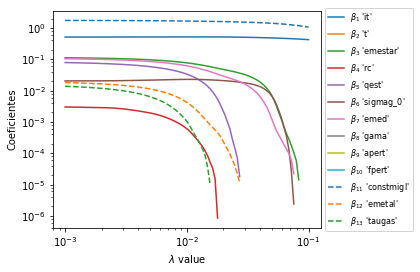

In [6]:
fig, ax = plot(multiple_lasso_testing(low_complete, 0, 100))
fig

### Total mass

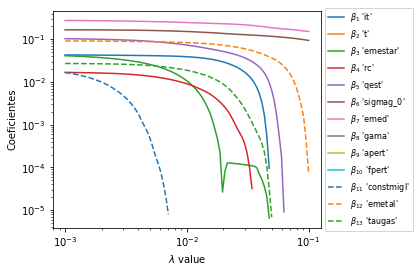

In [7]:
fig, ax = plot(multiple_lasso_testing(low_complete, 1, 100))
fig

### Eficiencia

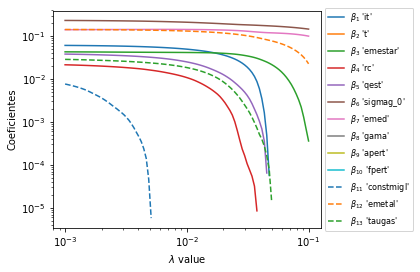

In [8]:
fig, ax = plot(multiple_lasso_testing(low_complete, 2, 100))
fig

In [36]:
wanted_index = 2
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

F, pval = f_regression(X_data, Y_data)

/home/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/home/juan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/juan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/juan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [37]:
print(F)
print(pval)

[   6.55084714           nan  118.36180379    5.28486227   26.89854509
  336.93133834  325.56191297           nan           nan           nan
   14.47225573   32.53837707    4.06047225]
[  1.05367975e-02              nan   5.12813798e-27   2.15867021e-02
   2.30100967e-07   4.66482455e-71   7.54046787e-69              nan
              nan              nan   1.45355771e-04   1.29402028e-08
   4.39959631e-02]


In [63]:
model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', LinearRegression(normalize=False,n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

0.14310691702275413

In [35]:
y_preds = np.rint(y_pred).astype(int)
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_preds))
print(sk.metrics.r2_score(Y_test, y_preds))

0.131627056673
0.36945209597


In [26]:
y_preds

array([13, 12, 12,  9, 12, 13, 11, 11, 12, 12, 13,  4,  8, 12, 11, 10, 12,
       11, 14, 11, 13, 10,  8, -5, 10,  8, 13, 14, 12, 12, 12, 12,  7, 11,
        8, 14, 13, 14, 10, 12, 11,  6,  6, 12, 11, 12, 10, 14, 11, 10, 10,
        3, 13, 12, 14, 11, 12, 13, 12, 11,  9, 12,  9, 10, 12, 13, 10, 13,
        5, 12, 13, 13,  9, 13, 11, 15, 12, 12, 10, 12, 11, 11, 14,  9,  7,
       14, 14, 12, 13, 12, 14, 13, 12, 12, 14, 15, 13, 12, 13, 12,  7, 12,
        8, 15, 11, 12, 12, 12, 13, 11, 12, 12,  9, 15, 14, 11, 12, 12, 11,
       13, 14, 11, 13, 12, 14, 13, 13, 12, 11, 11, 13, 15, 12, 10, 12, 11,
       12, 13, 12, 11, 12, 15, 12, 14, 15,  8, 13, 11, 12, 15,  9, 10,  9,
       12, 12, 12, 15, 12, 12, 13, 13, 13, 15, 14, 11, 15, 12, 14, 13, 11,
       14, 10, 11, 11, 11,  9, 13, 12, 12, 10, 10, 13, 12, 12, 12, 13, 14,
       11, 15, 12, 11, 12, 14, 12, 10, 12, 12, 11, 12, 11, 12, 13, 11, 12,
       12, 13, 12, 12, 12, 12, 14, 15, 14, 11, 13, 11, 14, 12, 12, 13,  7,
       12, 15,  9, 13, 15

In [48]:
#plk.dump(model, open('best2.p', 'wb'))

In [18]:
#svmf = Pipeline([('poly', PolynomialFeatures(degree=5,interaction_only=False)),('SVM', SVR())])
#svmf.fit(X_train, Y_train)

#y_pred = svmf.predict(X_test)
#sk.metrics.r2_score(Y_test, y_pred)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [110]:
multi = KNeighborsClassifier(n_neighbors=2000)

wanted_index = 0
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)

multi.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2000, p=2,
           weights='uniform')

In [111]:
y_pred = multi.predict(X_test)
accuracy_score(Y_test, y_pred)

0.10786106032906764

In [121]:
wanted_index = 1
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

#F, pval = f_regression(X_data, Y_data)

In [122]:
model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', KNeighborsRegressor(n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

-0.015326733935002501